In [1]:
from run_gom_mp import *
import pandas as pd
import xarray as xr
from datetime import timedelta as delta
from scipy import interpolate

from parcels import plotTrajectoriesFile

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean 

In [2]:
%run -i run_sim_backwards.py

total_sim_time_days = 30 * 6
fieldset, pset = run_gom_mp_backwards('testing_output/6m_nurdle_run.zarr', total_sim_time_days = total_sim_time_days)

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _version: The specified procedure could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
INFO: Compiled ArrayNurdleAdvectionRK4BeachTestingDisplaceBStokesUVBeachTestingSmagDiffBeachedAgeingBeachTesting ==> C:\Users\pojun\AppData\Local\Temp\parcels-tmp\lib0ae480449a21da68fb69dc8d25c54ed0_0.dll
INFO: Output files are stored in testing_output/6m_nurdle_run.zarr.
100%|██████████| 15552000.0/15552000.0 [31:54<00:00, 8124.44it/s]          


In [2]:
sim_output = xr.open_zarr('testing_output/6m_nurdle_run.zarr')
gom_masks = xr.open_dataset('data/gom_masks_w_inputs.nc')

c:\Users\pojun\anaconda3\envs\py3_parcels\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _version: The specified procedure could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


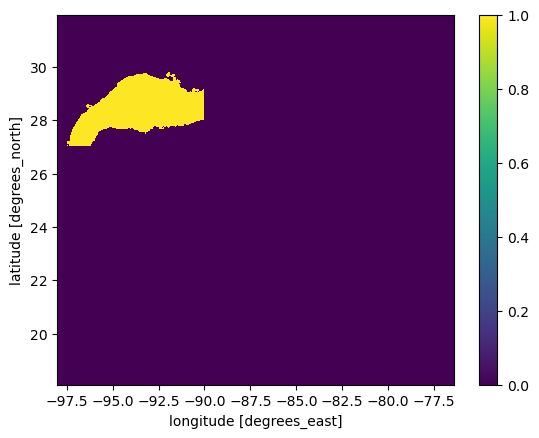

In [20]:
# LaTex Self
((gom_masks.depth < 500)  & (gom_masks.Longitude < -90.0) & (gom_masks.Latitude > 27.0)).plot()

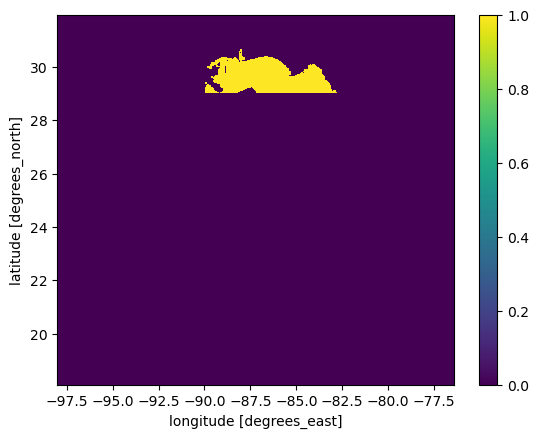

In [45]:
# nWFS Shelf
((gom_masks.depth < 1000) & (gom_masks.Longitude > -90.0) & (gom_masks.Latitude > 29.0) & (gom_masks.Longitude < -82.5)).plot()

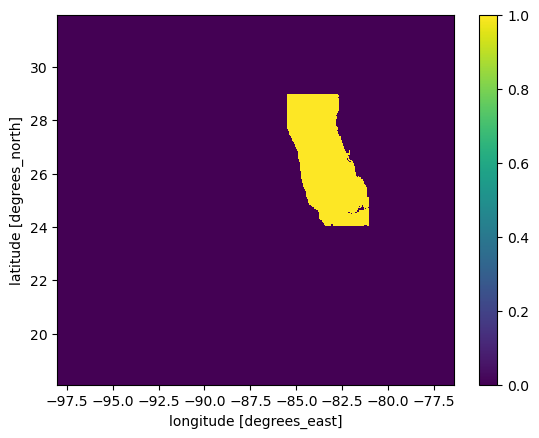

In [52]:
# sWFS
((gom_masks.depth < 1000) & (gom_masks.Longitude > -85.5) & (gom_masks.Longitude < -81.0) & (gom_masks.Latitude < 29.0) & (gom_masks.Latitude > 24.0)).plot()

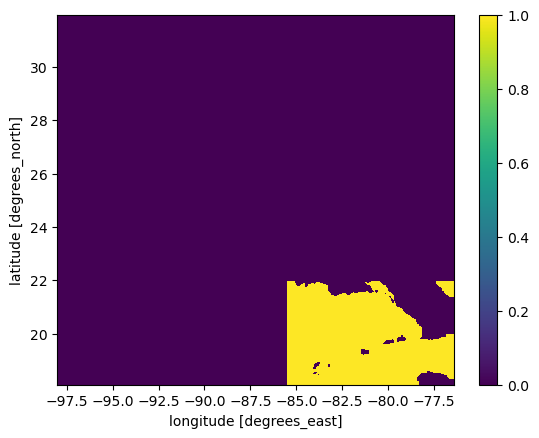

In [65]:
# Carribean
((gom_masks.depth > 1000) & (gom_masks.Longitude > -85.5) & (gom_masks.Latitude < 22.0)).plot()

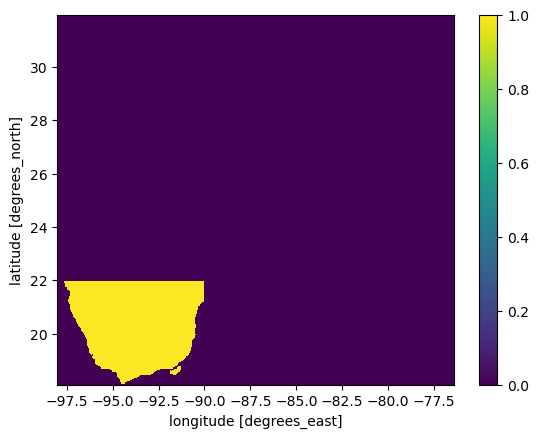

In [91]:
# Campeche bay
((gom_masks.depth < 5000) & (gom_masks.Latitude < 22.0) & (gom_masks.Longitude < -90.0)).plot()

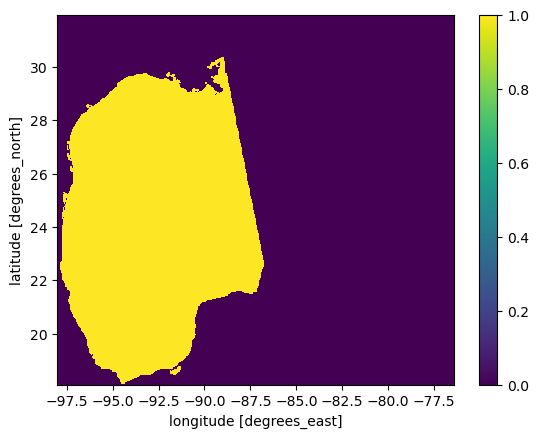

In [195]:
# weGOM
(((gom_masks.Latitude) + 3.5*(gom_masks.Longitude + 88) < 27) & ((gom_masks.Latitude) - 2.5*(gom_masks.Longitude + 85) > 27) & (gom_masks.depth > -1.0)).plot()

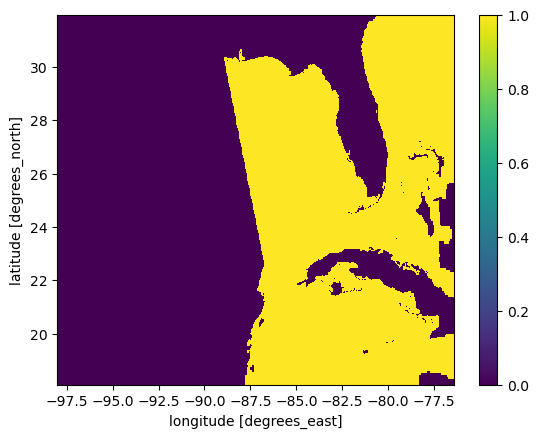

In [200]:
# eeGOM
(~(((gom_masks.Latitude) + 3.5*(gom_masks.Longitude + 88) < 27) & ((gom_masks.Latitude) - 2.5*(gom_masks.Longitude + 85) > 27)) & (gom_masks.depth > -1.0)).plot()

In [7]:
gm_lons = gom_masks['Longitude'].values
gm_lons = np.append(gm_lons, [gm_lons[-1] + CELL_SIZE, gm_lons[-1] + 2*CELL_SIZE])
cell_lons =  gm_lons[:-1] - (np.diff(gm_lons)/2)

gm_lats = gom_masks['Latitude'].values
gm_lats = np.append(gm_lats, [gm_lats[-1] + CELL_SIZE, gm_lats[-1] + 2*CELL_SIZE])
cell_lats =  gm_lats[:-1] - (np.diff(gm_lats)/2)

In [14]:
# Velocity nodes
lon_vals, lat_vals = np.meshgrid(gom_masks['Longitude'], gom_masks['Latitude'])
lons_plot = lon_vals
lats_plot = lat_vals

landmask = gom_masks.landmask

# Centers of the gridcells formed by 4 nodes = velocity nodes + 0.5 dx
x = gom_masks['Longitude'][:-1]+np.diff(gom_masks['Longitude'])/2
y = gom_masks['Latitude'][:-1]+np.diff(gom_masks['Latitude'])/2
lon_centers, lat_centers = np.meshgrid(x, y)

# Interpolate the landmask to the cell centers - only cells with 4 neighbouring land points will be land
fl = interpolate.interp2d(gom_masks['Longitude'],gom_masks['Latitude'],landmask)
l_centers = fl(lon_centers[0,:],lat_centers[:,0])  
lmask = np.ma.masked_values(l_centers,1) # land when interpolated value == 1
    
def quick_display_parcels(title = 'No Title'):
    fig = plt.figure(figsize=(6,6), constrained_layout=True)
    ax0 = plt.axes()
    ax0.set_ylabel('Latitude [degrees]')
    ax0.set_xlabel('Longitude [degrees]')
    ax0.set_title(title)
    land = ax0.pcolormesh(lon_vals, lat_vals, lmask.mask,cmap=cmocean.cm.topo)
    #ax0.scatter(lons_plot, lats_plot, c=landmask,s=25,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')

    return ax0

In [20]:
sim_output_dd = sim_output.to_dask_dataframe()

C:\Users\pojun\AppData\Local\Temp\ipykernel_1280\282428563.py:3: RuntimeWarning: divide by zero encountered in log10
  _ = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap=cmocean.cm.tempo, rasterized=True, alpha = 0.7)


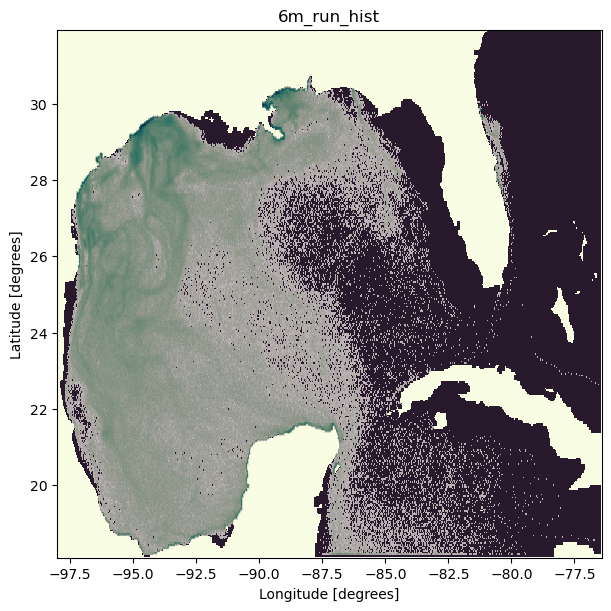

In [23]:
ax = quick_display_parcels('6m_run_hist')
H, xedges, yedges = np.histogram2d(sim_output_dd.lon, sim_output_dd.lat, bins=(cell_lons, cell_lats))
_ = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap=cmocean.cm.tempo, rasterized=True, alpha = 0.7)